# Final Project Medical Imaging
# Point 2
Alejandro Cedillo Gamez

In [153]:
import pydicom
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import cv2
import scipy
from scipy.ndimage import zoom, rotate
from skimage import exposure
import helper as h

### Get Folder directories

In [154]:
fixed_10_folder = "1196/10_AP_Ax5.00mm"  # reference 
moving_30_folder    = "1196/30_EQP_Ax5.00mm"  # register


### Get all elements from directories

In [155]:
def get_slices(folder):
    all_slices = [
        pydicom.dcmread(os.path.join(root, fname))
        for root, _, files in os.walk(folder)
        for fname in sorted(files)
        if fname.lower().endswith('.dcm')
    ]
    return all_slices

In [156]:
moving_slices = get_slices(moving_30_folder)
fixed_slices = get_slices(fixed_10_folder)

In [157]:
moving_slices[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 180
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.5.34343107.11676.1605770289.644
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'REFORMATTED', 'AVERAGE']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: '110603'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0017) Acquisition UID

### Load volume from slices

In [158]:
def get_volume(slices):
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    my_volume = np.stack([s.pixel_array for s in slices], axis=0)
    return my_volume

In [159]:
moving_vol = get_volume(moving_slices)
fixed_vol = get_volume(fixed_slices)

In [160]:
z_positions = [float(ds.ImagePositionPatient[2]) for ds in moving_slices]

### Preprocess data

In [161]:
# fixed_vol = rotate(fixed_vol, 180, axes=(0, 2), reshape=False)
# moving_vol = rotate(fixed_vol, 180, axes=(0, 2), reshape=False)


In [162]:
fixed_vol   = h.normalize(fixed_vol)
moving_vol  = h.normalize(moving_vol)

In [163]:
moving_vol = np.flip(moving_vol,axis=0)
fixed_vol = np.flip(fixed_vol,axis=0)

### Spacing between elements
```
spacing = ( 
    float(slices[0].SpacingBetweenSlices),  # Δz (slice thickness) 
    float(slices[0].PixelSpacing[0]),       # Δy (row spacing) 
    float(slices[0].PixelSpacing[1])        # Δx (column spacing) 
)
```

- See: https://dicom.innolitics.com/ciods/rt-dose/image-plane/00280030
- See: https://dicom.innolitics.com/ciods/ct-performed-procedure-protocol/performed-ct-reconstruction/00189934/00180088

In [164]:
slice_thickness = abs(z_positions[1] - z_positions[0])
slice_thickness

5.0

In [165]:
# We need to know the pixel spacing of the slices to rescale the images, and have the right aspect ratio (mm/pixel)
# The pixel spacing is the same for all slices, so we can just take the first slice
moving_slices[0].PixelSpacing # x and y pixel spacing

[0.703125, 0.703125]

In [166]:
fixed_slices[0].PixelSpacing

[0.703125, 0.703125]

In [167]:
# now that we know moving_slices[0].PixelSpacing[0] and moving_slices[0].PixelSpacing[1] are the same value
# we can save just one
mov_spacing_val = float(moving_slices[0].PixelSpacing[0])
fixed_spacing_val = float(fixed_slices[0].PixelSpacing[0])

pixel_len_mm = [slice_thickness, mov_spacing_val]


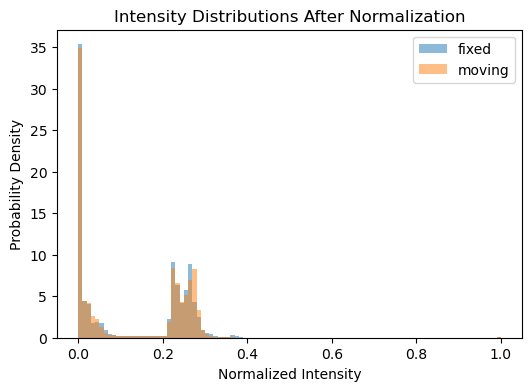

In [168]:
import matplotlib.pyplot as plt

# assume fixed_vol and moving_vol are your normalized NumPy arrays
fixed_vals  = fixed_vol .ravel()
moving_vals = moving_vol.ravel()

plt.figure(figsize=(6,4))
plt.hist(fixed_vals,  bins=100, alpha=0.5, label='fixed',  density=True)
plt.hist(moving_vals, bins=100, alpha=0.5, label='moving', density=True)
plt.title("Intensity Distributions After Normalization")
plt.xlabel("Normalized Intensity")
plt.ylabel("Probability Density")
plt.legend()
plt.show()


In [169]:
zf0, yf0, xf0 = fixed_vol.shape[0]//2, fixed_vol.shape[1]//2, fixed_vol.shape[2]//2
zm0, ym0, xm0 = moving_vol.shape[0]//2, moving_vol.shape[1]//2, moving_vol.shape[2]//2

Text(0.5, 1.0, 'Sagittal Plane (moving)')

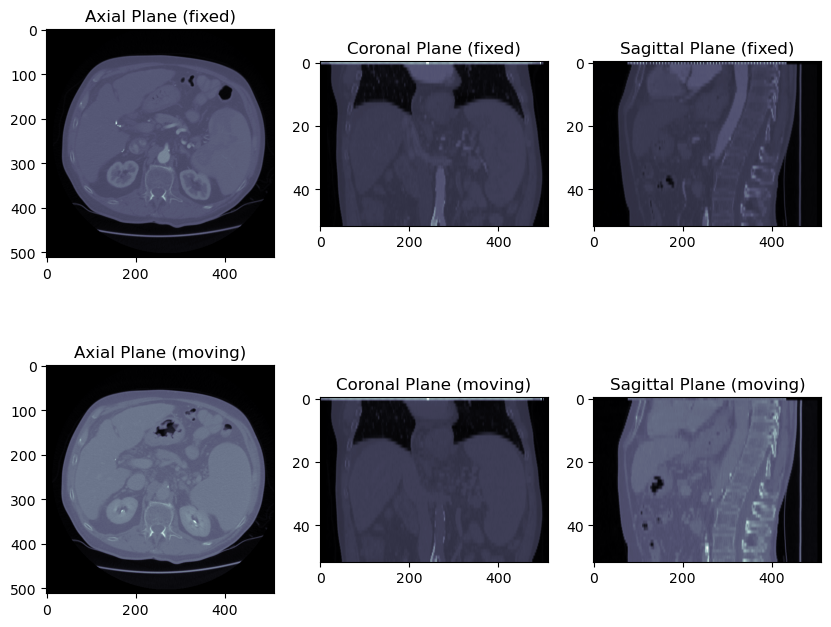

In [170]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))

axs[0, 0].imshow(fixed_vol[fixed_vol.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[0, 0].set_title("Axial Plane (fixed)")
axs[0, 1].imshow(fixed_vol[:, fixed_vol.shape[1] // 2, :], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 1].set_title("Coronal Plane (fixed)")
axs[0, 2].imshow(fixed_vol[:, :, fixed_vol.shape[2] // 2], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[0, 2].set_title("Sagittal Plane (fixed)")


# scan_3d visualization
axs[1, 0].imshow(moving_vol[moving_vol.shape[0] // 2, :, :], cmap='bone', aspect=1)
axs[1, 0].set_title("Axial Plane (moving)")
axs[1, 1].imshow(moving_vol[:, moving_vol.shape[1] // 2, :], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 1].set_title("Coronal Plane (moving)")
axs[1, 2].imshow(moving_vol[:, :, moving_vol.shape[2] // 2], cmap='bone', aspect=pixel_len_mm[0]/pixel_len_mm[1])
axs[1, 2].set_title("Sagittal Plane (moving)")

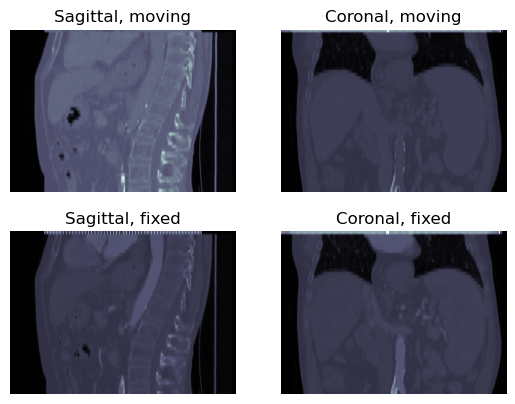

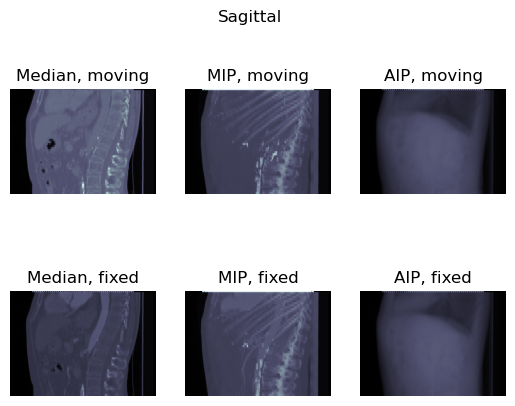

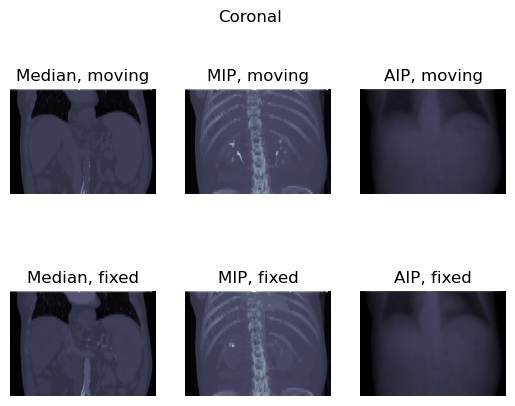

In [171]:
# Show median planes
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(h.median_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Sagittal, moving')
ax[0,1].imshow(h.median_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('Coronal, moving')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Sagittal, fixed')
ax[1,1].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('Coronal, fixed')
for a in ax.flat:
    a.axis('off')
# fig.suptitle('Median planes')
plt.show()

# Show MIP/AIP/Median planes
fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(h.median_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, moving')
ax[0,1].imshow(h.MIP_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, moving')
ax[0,2].imshow(h.AIP_sagittal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, moving')

ax[1,0].imshow(h.median_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_sagittal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Sagittal')
for a in ax.flat:
    a.axis('off')
plt.show()


fig, ax = plt.subplots(2, 3)
ax[0,0].imshow(h.median_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,0].set_title('Median, moving')
ax[0,1].imshow(h.MIP_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,1].set_title('MIP, moving')
ax[0,2].imshow(h.AIP_coronal_plane(moving_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0,2].set_title('AIP, moving')

ax[1,0].imshow(h.median_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,0].set_title('Median, fixed')
ax[1,1].imshow(h.MIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,1].set_title('MIP, fixed')
ax[1,2].imshow(h.AIP_coronal_plane(fixed_vol), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1,2].set_title('AIP, fixed')
fig.suptitle('Coronal')

for a in ax.flat:
    a.axis('off')
plt.show()

ModuleNotFoundError: No module named 'SimpleITK'